El objetivo de esta segunda parte es crear una base de datos que almacenen el valor nutricional y la receta de los platos del dataset. Para ello utilizaremos diferentes Apis para obtener todos estos datos y cargarlos en el dataset que creemos.

## **2. Definiendo la base de datos de calorías**

Necesitamos crear un dataset con todos los platos que el modelo predecirá y para ello sacaremos los datos de nutrición (calorías, grasas, hidratos...) de dichos platos.

Para obtener información nutricional utilizaremos la API de fat secret que es una página que proporciona datos detallados sobre calorías, macronutrientes y otros valores nutricionales de una amplia variedad de alimentos, incluyendo productos genéricos y de marca.

link: https://www.fatsecret.es/Default.aspx?pa=m

Nuestro objetivo es mediante la API extraer cada uno de los valores nutricionales de cada plato y crear un conjunto de datos que luego utilizaremos más adelante.

Para ello descargaremos la libreria load_dotenv para cargar variables de entorno desde un archivo. Esto es útil cuando se cargan claves que no se quiere quee se sepan como en este caso, queremos cargar nuestras clases de la API que no tienen porque verlas otras personas

In [ ]:
!pip install load_dotenv # instalo esta librería para cargar variables de entorno desde un archivo .env

Importaré otra serie de librerias que necesitaré para esta parte del proyecto

In [ ]:
import requests  # para las peticiones de la API
import time #para controlar el tiempo de las peticiones para no saturarla
import random
import urllib.parse  # lo usaré para la manipulación de URLs (codificación y decodificación)
import hmac  # para crear firmas HMAC (autenticación y verificación)
import hashlib  # para generar hashes (SHA-256, MD5, etc.)
import base64  # para codificación y decodificación en base64
import pandas as pd
import re  #  búsquedas y manipulaciones de texto
import os  # interacción con el sistema operativo
from dotenv import load_dotenv  # para cargar variables de entorno desde un archivo .env
import numpy as np

Nos conectamos a google drive para acceder a los archivos


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Se cogerá del diccionario con las clases que tenemos en nuestro drive y después de convertirlo a lista, iteraremos por cada nombre de plato llamando a la API de fat secret y que vaya buscando su valor nutricional uno a uno

In [ ]:
 ruta_clases = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/clases_food101.npy"


# Cargo el diccionario desde el archivo .npy
diccionario_clases = np.load(ruta_clases, allow_pickle=True).item()

 print(diccionario_clases)


{0: 'Apple pie', 1: 'Baby back ribs', 2: 'Baklava', 3: 'Beef carpaccio', 4: 'Beef tartare', 5: 'Beet salad', 6: 'Beignets', 7: 'Bibimbap', 8: 'Bread pudding', 9: 'Breakfast burrito', 10: 'Bruschetta', 11: 'Caesar salad', 12: 'Cannoli', 13: 'Caprese salad', 14: 'Carrot cake', 15: 'Ceviche', 16: 'Cheesecake', 17: 'Cheese plate', 18: 'Chicken curry', 19: 'Chicken quesadilla', 20: 'Chicken wings', 21: 'Chocolate cake', 22: 'Chocolate mousse', 23: 'Churros', 24: 'Clam chowder', 25: 'Club sandwich', 26: 'Crab cakes', 27: 'Creme brulee', 28: 'Croque madame', 29: 'Cup cakes', 30: 'Deviled eggs', 31: 'Donuts', 32: 'Dumplings', 33: 'Edamame', 34: 'Eggs benedict', 35: 'Escargots', 36: 'Falafel', 37: 'Filet mignon', 38: 'Fish and chips', 39: 'Foie gras', 40: 'French fries', 41: 'French onion soup', 42: 'French toast', 43: 'Fried calamari', 44: 'Fried rice', 45: 'Frozen yogurt', 46: 'Garlic bread', 47: 'Gnocchi', 48: 'Greek salad', 49: 'Grilled cheese sandwich', 50: 'Grilled salmon', 51: 'Guacamole

In [ ]:
print(f"La lista de los platos contiene {len(diccionario_clases)} clases.")

La lista de los platos contiene 101 clases.


In [ ]:
clases_modelo = list(diccionario_clases.values())
print(clases_modelo[:13])

['Apple pie', 'Baby back ribs', 'Baklava', 'Beef carpaccio', 'Beef tartare', 'Beet salad', 'Beignets', 'Bibimbap', 'Bread pudding', 'Breakfast burrito', 'Bruschetta', 'Caesar salad', 'Cannoli']


Guardare en un archivo .env que crearé ahora, las claves de la API  y con getpass podré escribirlas solo para mi como de una contraseña se tratase ya que no se verá más que la contraseña codificada. Después las guardaré en el archivo .env

In [ ]:
env_path = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/.env"

In [ ]:




# Pedir credenciales de forma segura
import getpass

consumer_key = getpass.getpass("Introduce tu CONSUMER_KEY: ")
consumer_secret = getpass.getpass("Introduce tu CONSUMER_SECRET: ")

# Guardar las credenciales en el archivo .env
with open(env_path, "w") as f:
    f.write(f"CONSUMER_KEY={consumer_key}\n")
    f.write(f"CONSUMER_SECRET={consumer_secret}\n")

print(f"Archivo .env guardado en {env_path}")


Introduce tu CONSUMER_KEY: ··········
Introduce tu CONSUMER_SECRET: ··········
Archivo .env guardado en /content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/.env


Con este código obtendremos información nutricional de platos identificados por el modelo de clasificación de imágenes, utilizando la API de FatSecret. Para ello, cargaremos las credenciales desde el archivo .env, extrayendo CONSUMER_KEY y CONSUMER_SECRET para la autenticación.

Luego, haremos una función para generar los parámetros de autenticación OAuth, incluyendo la firma HMAC-SHA1, necesaria para que la API valide la solicitud.

A continuación, iteraremos sobre cada plato en la lista clases_modelo, realizando una consulta a la API para obtener información nutricional. Una vez recibe la respuesta, intentará seleccionar el primer resultado de tipo "Generic", que representa la versión más estándar del alimento, pero en caso de no encontrarlo, usará el primer resultado disponible. Si la API devuelve una descripción del alimento, la función parse_nutrition() extrae los valores de calorías, grasas, carbohidratos y proteínas mediante expresiones regulares.

Toda esta información se almacena en una lista de diccionarios donde se registran los datos del plato original, el nombre devuelto por la API, los valores nutricionales y el enlace a la página de la API correspondiente.

Si la consulta no arroja resultados, se almacenan valores None en su lugar. Además, se incluyen medidas para manejar errores de conexión o respuestas vacías de la API, y se introduce un time.sleep(1) entre cada consulta para evitar hacer demasiadas peticiones en poco tiempo y así prevenir bloqueos por parte de la API.

Por último todos los datos recolectados se convierten en un DataFrame de Pandas y se guardan en un archivo CSV en Google Drive bajo el nombre food_nutrition_data.csv, para así tener con una base de datos estructurada con información nutricional de los platos analizados.

In [ ]:
CONSUMER_KEY = os.getenv("CONSUMER_KEY")
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET")


In [ ]:
print(CONSUMER_KEY)
print(CONSUMER_SECRET)

None
None


In [ ]:
# Cargo las credenciales desde .env

load_dotenv(env_path)

CONSUMER_KEY = os.getenv("CONSUMER_KEY")
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET")

# URL del endpoint
URL = "https://platform.fatsecret.com/rest/server.api"

# Función para obtener la firma OAuth
def get_oauth_params(search_query):
    oauth_params = {
        "oauth_consumer_key": CONSUMER_KEY,
        "oauth_nonce": str(random.randint(0, 100000000)),
        "oauth_signature_method": "HMAC-SHA1",
        "oauth_timestamp": str(int(time.time())),
        "oauth_version": "1.0",
        "method": "foods.search",
        "search_expression": search_query,
        "format": "json"
    }
    sorted_params = sorted(oauth_params.items())
    encoded_params = urllib.parse.urlencode(sorted_params, quote_via=urllib.parse.quote)
    base_string = f"GET&{urllib.parse.quote(URL, safe='')}&{urllib.parse.quote(encoded_params, safe='')}"
    signing_key = f"{CONSUMER_SECRET}&"
    hashed = hmac.new(signing_key.encode(), base_string.encode(), hashlib.sha1)
    signature = base64.b64encode(hashed.digest()).decode()
    oauth_params["oauth_signature"] = signature
    return oauth_params

# Función para extraer valores nutricionales
def parse_nutrition(description):
    match = re.search(r"Calories:\s([\d.]+)kcal\s\|\sFat:\s([\d.]+)g\s\|\sCarbs:\s([\d.]+)g\s\|\sProtein:\s([\d.]+)g", description)
    if match:
        return float(match.group(1)), float(match.group(2)), float(match.group(3)), float(match.group(4))
    return None, None, None, None  # Si falla la extracción

# Diccionario para almacenar los datos
nutrition_data = []

# Itero sobre cada plato en la lista de clases
for food in clases_modelo:
    print(f"Buscando información nutricional para: {food}...")

    # Obtengo parámetros OAuth y hago la petición
    params = get_oauth_params(food)
    response = requests.get(URL, params=params)

    if response.status_code == 200:
        data = response.json()
        foods = data.get("foods", {}).get("food", [])

        best_match = None

        # Busco el primer resultado de tipo "Generic"
        for item in foods:
            if isinstance(item, dict) and item.get("food_type") == "Generic":
                best_match = item
                break  # Tomo solo el primer genérico disponible

        # Si no hay genérico, tomo el primer resultado disponible
        if not best_match and isinstance(foods, list) and len(foods) > 0:
            best_match = foods[0]
            print(f"⚠ No se encontró versión genérica. Usando: {best_match.get('food_name', 'Desconocido')}")

        # Si encontramos algo, se extrae la información
        if best_match:
            food_name = best_match.get("food_name", "Desconocido")
            description = best_match.get("food_description", "")
            calories, fat, carbs, protein = parse_nutrition(description)

            # Guardo en la lista de datos
            nutrition_data.append({
                "Plato": food,
                "Nombre API": food_name,
                "Calorías (kcal)": calories,
                "Grasas (g)": fat,
                "Carbohidratos (g)": carbs,
                "Proteínas (g)": protein

            })
            print(f"✔ Datos obtenidos: {food_name} - {calories} kcal")
        else:
            print(f"❌ No se encontraron datos para {food}.")
            nutrition_data.append({
                "Plato": food,
                "Nombre API": "No encontrado",
                "Calorías (kcal)": None,
                "Grasas (g)": None,
                "Carbohidratos (g)": None,
                "Proteínas (g)": None
            })
    else:
        print(f"❌ Error en la API para {food}: {response.status_code}")

    time.sleep(1)  # Evito demasiadas peticiones rápidas

# Convierto a DataFrame de Pandas
df = pd.DataFrame(nutrition_data)

# Guardo en un CSV
csv_path = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food_nutrition_data.csv"
df.to_csv(csv_path, index=False)

print(f"\nBase de datos generada: {csv_path}")
print(df.head())


Buscando información nutricional para: Apple pie...
✔ Datos obtenidos: Apple Pie - 265.0 kcal
Buscando información nutricional para: Baby back ribs...
⚠ No se encontró versión genérica. Usando: Baby Back Ribs
✔ Datos obtenidos: Baby Back Ribs - 210.0 kcal
Buscando información nutricional para: Baklava...
✔ Datos obtenidos: Baklava - 5246.0 kcal
Buscando información nutricional para: Beef carpaccio...
✔ Datos obtenidos: Carpaccio - 119.0 kcal
Buscando información nutricional para: Beef tartare...
✔ Datos obtenidos: Steak Tartare (Raw Ground Beef and Egg) - 210.0 kcal
Buscando información nutricional para: Beet salad...
✔ Datos obtenidos: Russian Salad - 1217.0 kcal
Buscando información nutricional para: Beignets...
✔ Datos obtenidos: Doughnut (Raised or Yeast) - 403.0 kcal
Buscando información nutricional para: Bibimbap...
⚠ No se encontró versión genérica. Usando: Korean Style Bibimbap Beef
✔ Datos obtenidos: Korean Style Bibimbap Beef - 340.0 kcal
Buscando información nutricional para

### Probando nuestro modelo con una imagen y que nos de la estimación nutricional


Guarde en un archivo python llamado utils la función que necesito para predecir el plato. Simplemente la importo

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/')

import utils


In [ ]:
from utils import predecir_imagen  # Ahora importo la función para predecir

In [ ]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def predecir_plato_y_nutricion(ruta_imagen, modelo, clases, df_nutricion):
    # Cargo la imagen
    img = cv2.imread(ruta_imagen)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen en {ruta_imagen}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (198, 198))  # Ajustar al tamaño del modelo
    img_array = img / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)

    # Hago la predicción
    prediccion = modelo.predict(img_array, verbose = 0)
    clase_predicha = np.argmax(prediccion)
    nombre_clase = clases.get(clase_predicha, f"Clase {clase_predicha}")

    # Muestro imagen con el nombre del plato predicho
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicción: {nombre_clase}")
    plt.show()

    # Busco en el dataset de nutrición
    info_nutricion = df_nutricion[df_nutricion["Plato"].str.lower() == nombre_clase.lower()]

    if not info_nutricion.empty:
        print(f"Información nutricional de {nombre_clase}:")
        print(info_nutricion.to_string(index=False))
    else:
        print(f"⚠ No se encontró información nutricional exacta para '{nombre_clase}'.")

        # Intento encontrar el más parecido
        coincidencias = df_nutricion[df_nutricion["Plato"].str.contains(nombre_clase.split()[0], case=False, na=False)]

        if not coincidencias.empty:
            print("Plato más similar encontrado en la base de datos:")
            print(coincidencias.head(1).to_string(index=False))
        else:
            print("❌ No se encontraron platos similares en la base de datos.")

# Rutas necesarias
ruta_modelo = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/mobilenet_food101_checkpoint.h5"
ruta_clases = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/clases_food101.npy"
ruta_nutricion = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/food_nutrition_data.csv"

# Cargo modelo
modelo = tf.keras.models.load_model(ruta_modelo)

# Cargo clases
clases = np.load(ruta_clases, allow_pickle=True).item()

# Cargo dataset nutricional
df_nutricion = pd.read_csv(ruta_nutricion)



## Probando con una imágen

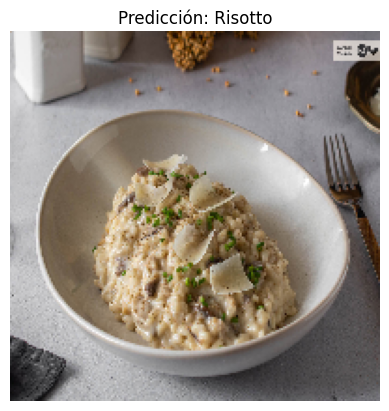

Información nutricional de Risotto:
  Plato     Nombre API  Calorías (kcal)  Grasas (g)  Carbohidratos (g)  Proteínas (g)
Risotto Cheese Risotto           1382.0       50.94              171.8          54.44


In [ ]:

test_image_path = "/content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/imagenes_prueba/rissoto.jpg"
predecir_plato_y_nutricion(test_image_path, modelo, clases, df_nutricion)


##**Añadiendo la receta**

En este apartado no solo sacaremos la predicción del plato y el valor nutricional, sino que también sacaremos la receta. Para ello utilizaremos otra API, y agregaremos una columna de receta a nuestra base de datos ya existente de los valore nutricionales.

Utilizaremos la API de Edamam que es una plataforma que ofrece APIs y servicios relacionados con la nutrición y la alimentación. Su objetivo principal es facilitar el acceso a información nutricional y herramientas para analizar y crear recetas saludables.

URL --> https://www.edamam.com/

Como antes guardaremos nuestras claves de la Api de manera segura de esta forma

In [ ]:
app_id = getpass.getpass("Introduce tu APP_ID: ")
app_key = getpass.getpass("Introduce tu APP_KEY: ")
user_id = getpass.getpass("Introduce tu USER_ID: ")

# GuardO las credenciales en el archivo .env
with open(env_path, "w") as f:
    f.write(f"APP_ID={app_id}\n")
    f.write(f"APP_KEY={app_key}\n")
    f.write(f"USER_ID={user_id}\n")

print(f"Archivo .env guardado en {env_path}")


Introduce tu APP_ID: ··········
Introduce tu APP_KEY: ··········
Introduce tu USER_ID: ··········
Archivo .env guardado en /content/drive/MyDrive/tokio/deep_learning/proyecto_final_foodAi/.env


Haré una función que haga llamadas a la API utilizando nuestras claves, se cercione de que si la petición esta ok me devuelva un json con las respuestas que esperamos. Verificariamos con un código si hay recetas en la respuesta y de ser así lo formateamos un poco para que se vea de manera bonita y estilosa (y no un json). Probaremos con algo sencillo,y pondremos "carbonara" que nos saldrá alguna receta de pasta o algo similar relaccionado con ese nombre de plato.

In [ ]:
import requests

# Función para obtener ingredientes y URL de receta
def get_receta(plato):
    url_busqueda = f"https://api.edamam.com/api/recipes/v2?type=public&q={plato}&app_id={app_id}&app_key={app_key}"

    headers = {
        "Edamam-Account-User": user_id
    }

    response = requests.get(url_busqueda, headers=headers)

    if response.status_code == 200:
        data = response.json()

        if "hits" in data and len(data["hits"]) > 0:
            receta = data["hits"][0]["recipe"]
            ingredientes = "\n".join([f"- {ing['food']} ({ing['text']})" for ing in receta["ingredients"]])
            url_receta = receta["url"]
            return ingredientes, url_receta
    return "No disponible", "No disponible"


plato = "carbonara"
ingredientes, url_receta = get_receta(plato)

print("🥦 Ingredientes:")
print(ingredientes)
print("\n🔗 URL de la receta:")
print(url_receta)


🥦 Ingredientes:
- Pecorino Romano (50 grams Pecorino Romano (1.8 ounces) grated)
- egg (1 large egg)
- olive oil (2 tablespoons olive oil)
- black pepper (fresh ground black pepper to taste)
- Pancetta (170 grams Guanciale (6 ounces) Pancetta or Bacon will also work)
- pasta (170 grams dried pasta (6 ounces) boiled according to package directions)
- eggs (2 slow cooked eggs (optional))

🔗 URL de la receta:
http://norecipes.com/blog/spaghetti-carbonara-recipe/


Sabiendo que funciona podemos  agregar la columna de la url de la receta y otra de los ingredientes

In [ ]:
#Aplico la función a la columna "Plato" y expando en dos nuevas columnas
df_nutricion[["Ingredientes", "URL_Receta"]] = df_nutricion["Plato"].apply(lambda plato: pd.Series(get_receta(plato)))

# Guardar el dataset actualizado
df_nutricion.to_csv(ruta_nutricion, index=False)
print("Dataset actualizado con ingredientes y URLs de recetas.")

Dataset actualizado con ingredientes y URLs de recetas.


In [ ]:
df_nutricion

,Plato,Nombre API,Calorías (kcal),Grasas (g),Carbohidratos (g),Proteínas (g),Ingredientes,URL_Receta
0,Apple pie,Apple Pie,265.0,12.50,37.10,2.40,"- apples (2 Red apples, cored, peeled and cut ...",https://food52.com/recipes/55787-apple-pie-smo...
1,Baby back ribs,Baby Back Ribs,210.0,15.00,4.00,17.00,"- baby back ribs (1 or 2 racks baby back ribs,...",https://www.epicurious.com/recipes/food/views/...
2,Baklava,Baklava,5246.0,355.81,461.09,82.12,- granulated sugar (2 cups granulated sugar (1...,https://www.seriouseats.com/pistachio-baklava-...
3,Beef carpaccio,Carpaccio,119.0,2.62,0.00,22.31,- olive oil (2 tbsp. olive oil)\n- Parmesan ch...,https://www.delish.com/cooking/recipe-ideas/re...
4,Beef tartare,Steak Tartare (Raw Ground Beef and Egg),210.0,14.56,0.63,17.78,- sirloin (1 1/2 pounds fatty sirloin or chuck...,http://www.foodrepublic.com/2014/05/07/beef-ta...
...,...,...,...,...,...,...,...,...
96,Tacos,"Taco or Tostada with Beef, Cheese and Lettuce",221.0,12.65,16.20,10.88,- Vegetable Oil (2 tsp Vegetable Oil (picadill...,http://www.lottieanddoof.com/2009/07/picadillo/
97,Takoyaki,Takoyaki,1489.0,64.32,151.25,71.89,- oyster sauce (1 tablespoon oyster sauce)\n- ...,https://www.allrecipes.com/recipe/283774/takoy...
98,Tiramisu,Tiramisu,3944.0,253.62,340.15,66.47,- Crepes (Crepes (Makes 20 crepes))\n- butter ...,https://food52.com/recipes/5286-tiramisu-crepe...
99,Tuna tartare,Tuna,108.0,0.95,0.00,23.38,- mayonnaise (1 tablespoon mayonnaise)\n- soy ...,https://www.marthastewart.com/355745/spicy-tun...


Por último quiero comprobar si hay receta para todos los platos

In [ ]:
df_nutricion["Ingredientes"].value_counts()

,count
Ingredientes,
"- apples (2 Red apples, cored, peeled and cut into 4 slices)\n- greek yogurt (1 cup vanilla greek yogurt)\n- lemon juice (1 tablespoon lemon juice)\n- brown sugar (2 tablespoons brown sugar)\n- pie spice (1 1/2 teaspoons Apple pie spice)\n- cinnamon (1/2 teaspoon cinnamon)\n- ice (2 cups ice)",1
"- Potato Chips (1 recipe Extra-Crunchy Potato Chips (see note above))\n- soup mix (2 single-serving packets instant miso soup mix (about 20 grams))\n- nori (10 sheets seasoned nori snack sheets, crumbled)\n- Kosher salt (Kosher salt)",1
"- duck breasts (4 (8-ounce) Rohan or Peking duck breasts)\n- Coarse salt (Coarse salt and freshly ground pepper)\n- pepper (Coarse salt and freshly ground pepper)\n- shallot (1 shallot, finely chopped)\n- red wine (1 cup red wine, preferably Madiran)\n- Armagnac (1/2 cup Armagnac)\n- demi-glace (2 tablespoons store-bought duck-and-veal demi-glace such as D'Artagnan)",1
"- water (2 tablespoons water)\n- gelatin (1 teaspoon powdered unflavored gelatin)\n- Vegetable oil (Vegetable oil, if unmolding the panna cotta)\n- plain Greek yogurt (1 cup whole-milk plain Greek yogurt)\n- heavy cream (1 cup heavy cream, divided)\n- granulated sugar (1/4 cup granulated sugar)\n- bean paste (1/2 teaspoon vanilla bean paste or vanilla extract)\n- strawberries (1/2 cup sliced strawberries)\n- raspberries (1/2 cup raspberries)\n- granulated sugar (1 tablespoon granulated sugar)",1
"- all purpose flour (1 1/3 cups all purpose flour)\n- cocoa (1/3 cup plus 1 tablespoon cocoa powder)\n- cocoa (1/3 cup plus 1 tablespoon cocoa powder)\n- granulated sugar (6 tablespoons granulated sugar)\n- baking powder (1 1/2 teaspoons baking powder)\n- salt (3/4 teaspoon salt)\n- baking soda (1/4 teaspoon baking soda)\n- eggs (2 large eggs)\n- unsalted butter (3 tablespoons melted unsalted butter, plus extra for greasing pan and buttering pancakes)\n- whole milk (3/4 cup whole milk)\n- whole milk (1/2 cup whole milk)\n- semi-sweet chocolate (5 ounces semi-sweet chocolate, finely chopped)\n- vanilla extract (1 teaspoon pure vanilla extract)",1
...,...
"- egg whites (2 egg whites)\n- salt (1 pinch of salt)\n- muscovado sugar (40g light muscovado sugar)\n- breadcrumbs (50g breadcrumbs, finely ground)\n- butter (60g melted butter)\n- icing sugar (60g icing sugar)\n- maple syrup (15g maple syrup (ca. 1/2 tbsp))\n- milk (7g milk)\n- sea salt (1 pinch of sea salt)\n- walnuts (1-2 tablespoons crushed walnuts)",1
"- eggs (12 large eggs, hard boiled)\n- mayonnaise (1/3 cup mayonnaise)\n- gochujang (1 tablespoon gochujang, plus more to taste)\n- kimchi (1/2 cup finely diced kimchi)\n- chives (1 bunch chives, cut into 3-inch sections or minced)\n- sesame seeds (1 tablespoon white or black sesame seeds)\n- red chili (1 teaspoon Korean red chili, paprika, or cayenne (optional))",1
- butter (113 grams of butter)\n- caster sugar (113 grams of caster sugar)\n- eggs (2 eggs)\n- flour (113 grams of self raising flour)\n- baking powder (1 teaspoon baking powder)\n- vanilla extract (1 teaspoon vanilla extract),1


In [ ]:
df_nutricion["URL_Receta"].value_counts()

,count
URL_Receta,
https://food52.com/recipes/55787-apple-pie-smoothie,1
http://www.seriouseats.com/recipes/2015/01/miso-soup-potato-chips-recipe.html,1
https://www.marthastewart.com/902951/duck-breasts-la-dartagnan,1
https://www.thekitchn.com/recipe-greek-yogurt-panna-cotta-258338,1
http://www.seriouseats.com/recipes/2012/02/chocolate-pancakes-recipe.html,1
...,...
https://food52.com/recipes/22592-breadcrumb-baked-donuts-with-a-sea-salt-and-maple-glaze,1
https://www.simplyrecipes.com/recipes/kimchi_deviled_eggs/,1
https://food52.com/recipes/23641-sparkly-cup-cakes,1


In [ ]:
print(df_nutricion["URL_Receta"][5])

https://www.bonappetit.com/recipe/sardines-rye-crackers-whole-grain-mustard-dressing
